# Convoluciones

En este cuaderno vamos a aprender un poco de la operación fundamental de las redes convolucionales: la convolución. 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display

In [2]:
tf.enable_eager_execution()

Este tipo de redes fueron originalmente concebidas para análisis de imágenes, entonces empecemos por considerar dos imágenes.

In [3]:
images_path = os.path.join('..', 'images','N01_convoluciones')
botero_fpath = os.path.join(images_path, 'botero.jpg')
coltejer_fpath = os.path.join(images_path, 'coltejer.jpg')

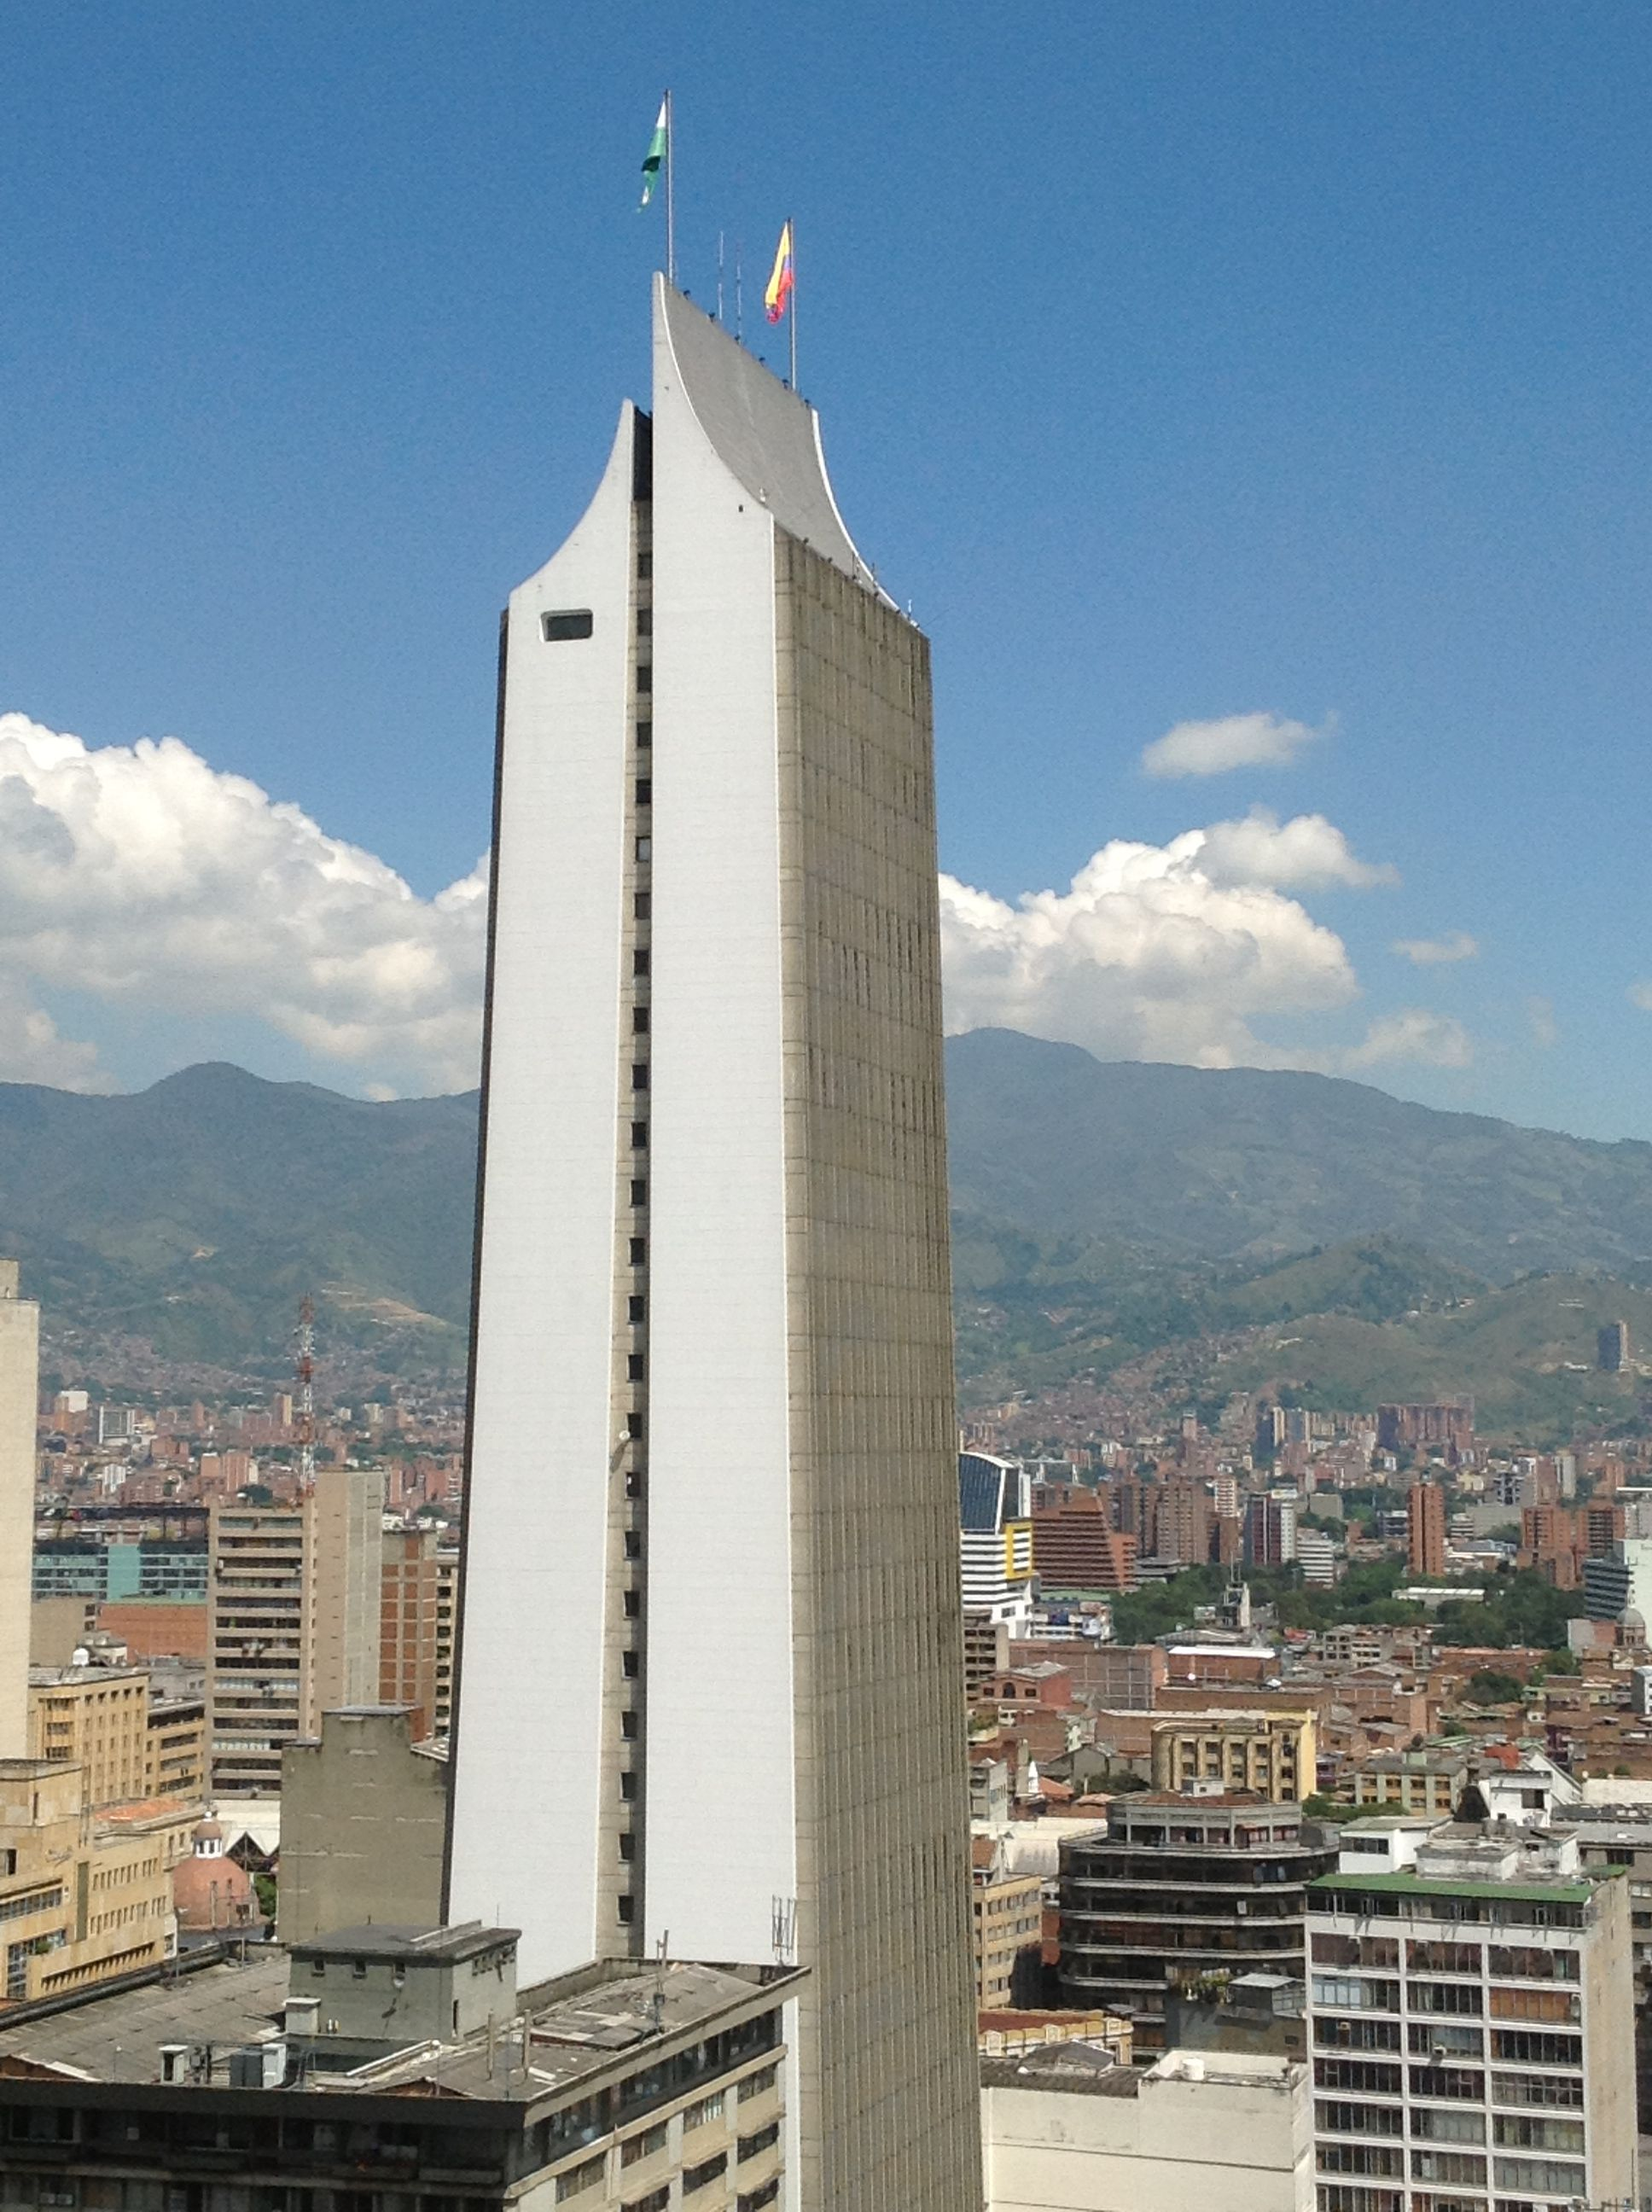

In [4]:
display.Image(coltejer_fpath, width=128)

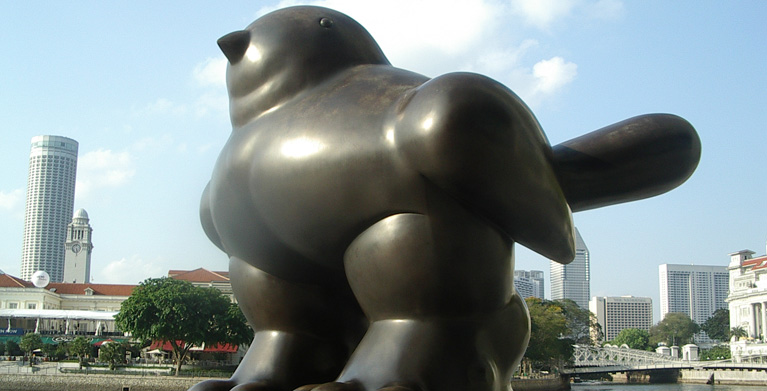

In [5]:
display.Image(botero_fpath, width=180)

La primera imagen es de un representativo edificio de la ciudad de medellín: el edificio Coltejer (fuente: https://www.pinterest.es/pin/300615343848037737/), mientars que la segunda corresponde a una obra de un reconocido artista de la ciudad: Fernando Botero (fuente: http://www.colombia.co/esta-es-colombia/talento/artistas/conoce-las-obras-mas-importantes-de-fernando-botero/).

Supongamos que queremos construir un algoritmo de clasificación que nos diga si en una imagen hay un  edificio o una obra de Botero. Como sabemos, los algoritmos de Machine Learning funcionan a partir de vectores de características, que corresponden a variables que representan el contexto de lo que quiero predecir o clasificar. Para nuestra tarea se hace evidente una característica: si sabemos que la imagen tiene líneas rectas es más probable que corresponda a un edificio que a una obra de Botero.

Primero vamos a cargar las imágenes como un arreglo en formato: (pixeles a lo alto, pixeles a lo ancho, número de canales)

In [6]:
botero_image = plt.imread(botero_fpath)
coltejer_image = plt.imread(coltejer_fpath)
msg = "Dimensión de la imagen del edificio: {}"
print(msg.format(coltejer_image.shape))
msg = "Dimensión de la imagen del Botero: {}"
print(msg.format(botero_image.shape))

Dimensión de la imagen del edificio: (2592, 1936, 3)
Dimensión de la imagen del Botero: (391, 767, 3)


Por conveniencia, vamos a trabajar con imágenes en escala de grises, pero esto no será necesario para construir aplicaciones.

In [7]:
botero_grayscale = np.mean(botero_image, axis=2, keepdims=True)
coltejer_grayscale = np.mean(coltejer_image, axis=2, keepdims=True)

miremos el resultado

(-0.5, 766.5, 390.5, -0.5)

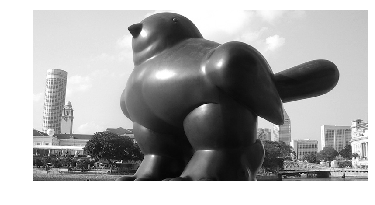

In [8]:
plt.imshow(botero_grayscale[...,-1], cmap='gray')
plt.axis('off')

(-0.5, 1935.5, 2591.5, -0.5)

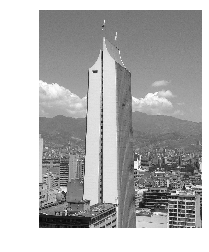

In [9]:
plt.imshow(coltejer_grayscale[...,-1], cmap='gray')
plt.axis('off')

Para detectar los bordes vamos a aplicar un filtro sobre la imagen. En procesamiento de imágenes, un filtro o un kernel, corresponde a una matriz que opera sobre una imagen y permite transformarla de la manera que especifica el filtro.

In [10]:
image_filter = np.array(
    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
).reshape(3, 3, 1, 1)

miremos cómo se ve el filtro

(-0.5, 2.5, 2.5, -0.5)

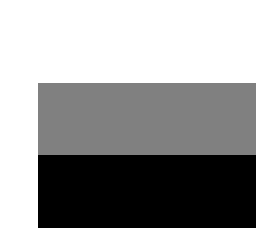

In [11]:
plt.imshow(image_filter[:,:,0,0], cmap='gray')
plt.axis('off')

este filtro efectivamente detecta líneas horizontales, ahora apliquemos el filtro a las imágenes

In [12]:
botero_convolved = tf.nn.conv2d(
    botero_grayscale.reshape((1, *botero_grayscale.shape)),
    image_filter,
    strides=[1, 1, 1, 1],
    padding='SAME'
).numpy()

coltejer_convolved = tf.nn.conv2d(
    coltejer_grayscale.reshape((1, *coltejer_grayscale.shape)),
    image_filter,
    strides=[1, 1, 1, 1],
    padding='SAME'
).numpy()

(-0.5, 766.5, 390.5, -0.5)

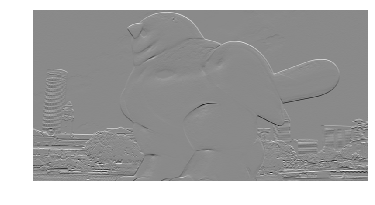

In [13]:
plt.imshow(botero_convolved[0, ..., 0], cmap='gray')
plt.axis('off')

(-0.5, 1935.5, 2591.5, -0.5)

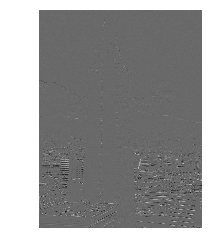

In [14]:
plt.imshow(coltejer_convolved[0, ..., 0], cmap='gray')
plt.axis('off')

Podemos ver que en el edificio ya no se ven las líneas verticales, porque esta no logran ser capturadas por el filtro. Para hacer este efecto más evidente, vamos a comparar la cantidad de ceros que tenían las imágenes antes y después de pasar por la convolución.

In [15]:
zeros_grayscale = np.sum(coltejer_grayscale == 0)
zeros_convolved = np.sum(coltejer_convolved == 0)
msg = "La imagen del {} pasó de {} a {} ceros"
print(msg.format('edificio', zeros_grayscale, zeros_convolved))
zeros_grayscale = np.sum(botero_grayscale == 0)
zeros_convolved = np.sum(botero_convolved == 0)
print(msg.format('Botero', zeros_grayscale, zeros_convolved))

La imagen del edificio pasó de 7 a 188297 ceros
La imagen del Botero pasó de 3 a 13719 ceros


En palabras, las convoluciones aplican el filtro en las diferentes regiones de la imágen, generando una nueva un nuevo valor por cada una de las regiones de la imagen por donde fue aplicada. La forma de aplicar el filtro es desplasando una ventana, del tamaño del filtro, por todda la imagen, moviéndose un pixel a la vez en cada dirección.

![imagen que explica la convolución](../images/N01_convoluciones/convolution2.gif)

Esta operación resulta en una reducción de la dimensión de la imagen, en particular, si tenemos una imagen de $n \times m$ pixeles y un filtro de $f \times f$, la imagen resultante después de la convolución sería de dimensión $(n-f+1) \times (m-f+1)$. Esta reducción de la dimensión puede controlarse con el argumento `padding` de la función [`tf.nn.conv2d`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). Si no queremos una reducción de la dimensión, definiendo `padding='SAME'`rellena los bordes de la imagen con ceros para poder llegar a un resultado con la misma dimensión de la imagen original.

![imagen que explica SAME padding](../images/N01_convoluciones/same_padding.gif)

Incluso podríamos rellenar la imágen con $p$ capas de ceros, lo que resultaría en imágenes de dimensión $(n +2p -f +1) \times (m+2p -f +1)$.

Esta operación también es posible aplicarla moviéndose cada $s$ pixeles en lugar de solo 1, lo que resultaría en una imagen más pequeña: $(\frac{n + 2p - f}{s} + 1) \times (\frac{m + 2p - f}{s} + 1)$. El parámetro `strides` de la función [`tf.nn.conv2d`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) nos permite especificar cuántos pasos se deben dar en cada dimensión del tensor de imagen.


In [16]:
tf.nn.conv2d(
    botero_grayscale.reshape((1, *botero_grayscale.shape)),
    image_filter,
    strides=[1, 2, 2, 1],
    padding='VALID'
).numpy().shape

(1, 195, 383, 1)

In [17]:
botero_grayscale.shape

(391, 767, 1)

Como dije antes, las convoluciones pueden aplicarse a cada canal de la imagen. Para hacerlo simplemente se necesita repetir el filtro tantas veces como canales tenga la imagen original. Además el número canales de la imagen resultante puede ser tan grande o pequeño como queramos.

In [18]:
image_filter_3d = np.array([image_filter.reshape(3, 3)]*3).reshape(3,3,3,1)
image_filter_3d.shape

(3, 3, 3, 1)

In [19]:
graph = tf.Graph()
with graph.as_default():
    input_image = tf.placeholder(tf.float32, shape=[1, None, None, 3])
    
    image_filter_3d = tf.constant(
        np.array(
            [image_filter.reshape(3, 3)]*3
        ).reshape(3,3,3,1).astype(np.float32)
    )
    
    convolved_image = tf.nn.conv2d(
        input_image,
        image_filter_3d,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )
    

In [20]:
with tf.Session(graph=graph) as sess:
    botero_convolved_3d = sess.run(
        [convolved_image],
        feed_dict={
            input_image: botero_image.reshape(
                (1, *botero_image.shape)).astype(np.float32)
        }
    )
  


(-0.5, 766.5, 390.5, -0.5)

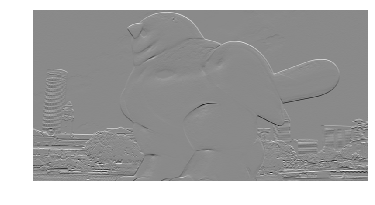

In [22]:
plt.imshow(botero_convolved[0, ..., 0], cmap='gray')
plt.axis('off')

En este ejemplo mostramos lo que pasaba si aplicábamos un filtro particular a una imagen. En una [red neuronal convolucional](http://www.deeplearningbook.org/contents/convnets.html), los valores del filtro son pesos de la forma $w_{ijk}$ que se aprenden mediante el proceso de optimización (gradiente descendiente, por ejemplo). En principio, lo que se pretende es que el algoritmo encuentre por si solo las características que son más relevantes en una imagen.